## 1. 모듈 임포트 (Module Import)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
%matplotlib inline

- torch. : 파이토치의 기본 모듈
- torch.nn : 인공신경망 모델을 설계할 때 필요한 함수를 모아 놓은 모듈
- torch.nn.functional : 자주 이용되는 함수를 F로 지정
- Computer Vision 연구 분야에서 자주 이용하는 torchvision 모듈 내 transforms, datasets 함수 임포트

## 2. 딥러닝 모델 설계할 때 쓰일 장비 확인

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version : ', torch.__version__, 'Device : ', DEVICE)

Using PyTorch version :  1.9.0 Device :  cuda


In [3]:
# 파이썬 코드 내 하이퍼파라미터를 지정할 때 보통 대문자로 쓴다.
BATCH_SIZE = 32
EPOCHS = 10

- BATCH_SIZE (미니배치 사이즈)
    - MLP 모델을 학습할 때 필요한 데이터 개수의 단위
    - Mini-Batch 1개 단위에 대해 데이터가 32개로 구성되어 있는 것을 의미
    - 총 데이터 수에 대해 미니배치로 한번 학습하는 것을 1 Iteration이라 함
- EPOCHS
    - 전체 데이터를 이용해 학습을 진행한 횟수

## 3. MNIST 데이터 다운로드(train set, test set 분리)

In [4]:
train_dataset = datasets.MNIST(root='./data/MNIST', train = True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data/MNIST', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

C:\Users\JAY\anaconda3\envs\torch_p38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


- transform
    - 이미지 데이터를 전처리 해준다.
    - ToTensor() 메서드를 통해 tensor로 변환해준다.
    - 0\~255 픽셀값을 0~1 범위로 정규화 해준다.
        - MLP 모델이 포함된 인공신경망 모델은 Input 데이터 값의 크기가 커질수록 불안정하거나 과적합되는 방향으로 학습이 진행될 우려가 있기 때문에 정규화 과정을 이용해 Input으로 이용하는 것을 권장
- DataLoader
    - Mini-Batch를 구성하게 해주는 함수
    - shuffle
        - MLP 모델이 학습을 진행할 때 Label 정보의 순서를 암기해 학습을 진행 할 수도 있다.
        - 즉, 특정 Label에 매칭된 이미지 데이터의 특징을 보고 학습하는 것이 아니라 특정 이미지 데이터에 매칭된 Label값만 집중적으로 학습하는 문제가 발생할 수 있다.
        - 잘못된 학습을 막기위해 데이터를 섞어 준다.

## 4. 데이터 확인

In [5]:
for X_train, y_train in train_loader:
    print(f'X_train : {X_train.size()}, type : {X_train.type()}')
    print(f'y_train : {y_train.size()}, type : {y_train.type()}')
    break
# 32개로 구성된 미니배치에 28x28이미지 크기, 1채널(grayscale)

X_train : torch.Size([32, 1, 28, 28]), type : torch.FloatTensor
y_train : torch.Size([32]), type : torch.LongTensor


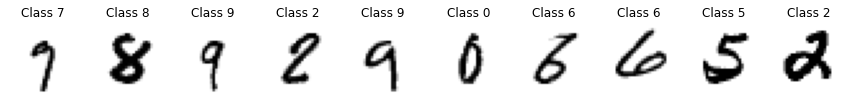

In [6]:
plt.figure(figsize=(15,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title('Class '+str(y_train[i].item()))

## 5. MLP(Multi Layer Perceptron) 모델 설계하기

In [44]:
class Net(nn.Module):
    
    # 여기서 인스턴스를 초기화해주고
    def __init__(self):
        super(Net, self).__init__()
        # fc1 : 28x28x1 인 이미지를 512 dense layer로 변환
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
        
    # 여기서 이제 계산을 어떻게 할지 forward propagation을 정의
    def forward(self, x):
        # view : 이게 tensorflow의 tf.keras.layers의 Flatten과 동일 
        x = x.view(-1, 28 * 28) # 여기서 -1은 28*28 사이즈를 맞추고 남은 차원을 알아서 채워준다는 의미다.
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

- `nn.Module` 클래스를 상속받는 Net 클래스를 정의
- `__init__(self):` : Net 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의해주는 메소드
- `super(Net, self).__init__()` : nn.Module 내에 있는 메소드를 상속받아 이용한다.

## 6. Optimizer, Objective Function 설정

In [45]:
model = Net().to(DEVICE) # 만든 모델을 cuda로 보냄

# 역전파를 수행할 optimizer를 지정한다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss() # oh이므로 crossentropy를 쓴다.

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## 7. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의

In [50]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward() # 역전파를 통해 얻어진 gradient값을 각 파라미터에 할당
        optimizer.step() # 각 파라미터에 할당된 값을 통해 파라미터를 새로 업데이터한다.
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch : {Epoch} [{batch_idx*len(image)}/{len(train_loader.dataset)}\
                  ({100. * batch_idx / len(train_loader):.0f}%)] \t Train Loss : {loss.item():.6f}')
            
            
            

## 8. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

In [1]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # 평가 단계에선 gradient가 업데이트가 되면 안되니까 미리 방지한다.
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy



## 9. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기

In [48]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH : {}], \tTest Loss : {:.4f}, \tTest Accuracy : {:.2f} %\n'.format(Epoch, test_loss, test_accuracy))

C:\Users\JAY\anaconda3\envs\torch_p38\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch : 1 [0/60000 (0%)] 	 Train Loss : 2.311524
Train Epoch : 1 [6400/60000 (11%)] 	 Train Loss : 2.322505
Train Epoch : 1 [12800/60000 (21%)] 	 Train Loss : 2.318094
Train Epoch : 1 [19200/60000 (32%)] 	 Train Loss : 2.271823
Train Epoch : 1 [25600/60000 (43%)] 	 Train Loss : 2.304710
Train Epoch : 1 [32000/60000 (53%)] 	 Train Loss : 2.260673
Train Epoch : 1 [38400/60000 (64%)] 	 Train Loss : 2.224057
Train Epoch : 1 [44800/60000 (75%)] 	 Train Loss : 2.256447
Train Epoch : 1 [51200/60000 (85%)] 	 Train Loss : 2.218744
Train Epoch : 1 [57600/60000 (96%)] 	 Train Loss : 2.239956

[EPOCH : 1], 	Test Loss : 0.0703, 	Test Accuracy : 10.10 %

Train Epoch : 2 [0/60000 (0%)] 	 Train Loss : 2.246693
Train Epoch : 2 [6400/60000 (11%)] 	 Train Loss : 2.220614
Train Epoch : 2 [12800/60000 (21%)] 	 Train Loss : 2.107483
Train Epoch : 2 [19200/60000 (32%)] 	 Train Loss : 2.083717
Train Epoch : 2 [25600/60000 (43%)] 	 Train Loss : 1.999727
Train Epoch : 2 [32000/60000 (53%)] 	 Train Loss : 